# Evaluating a diffusion model using a CNN

In [40]:
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from babel.messages.jslexer import division_re
from numpy.f2py.rules import defmod_rules
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import math
import numpy
# util files
from unet import SimpleUNet
from cnn import CNN

# other imports
from pathlib import Path
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class NormalizeTransform(nn.Module):
    """
    Transform that normalizes 1xnxn tensors to [0, 1]
    Works with dict input/output

    Taken from PyML course
    """
    def __init__(self):
        super(NormalizeTransform, self).__init__()

    def forward(self, data):
        """
        Args:
            data: dict with 'image' key containing torch.Tensor of shape (1, n, n)
        Returns:
            dict with normalized image in range [0, 1]
        """
        image = data[0]
        data[0] = (image - image.min()) / (image.max() - image.min() + 1e-8)
        return data

transform_list = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(14),
    NormalizeTransform()
])
data = "mnist"
train_dataset = datasets.MNIST(root=os.path.join("data", data), download=True, train=True, transform=transform_list)
wanted_class = 2
wanted_class_dataset = [d for d in train_dataset if d[1] == wanted_class]
wanted_class_loader = DataLoader(dataset=wanted_class_dataset, batch_size=64, shuffle=True)

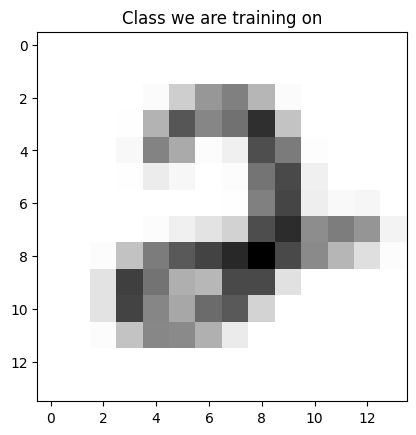

In [3]:
plt.imshow(1 - wanted_class_dataset[1][0].squeeze(), cmap="gray")
plt.title("Class we are training on")
plt.show()

In [4]:
class DDPMDiffusion:

    def __init__(
        self,
        time_steps: int, #discrete denoising steps in the diffusion process
        beta_start: float,
        beta_end: float,
        device: str='cpu',
    ):
        """
        This class handles the forward and the backward process of our diffusion model.
        Taken from PyML course.
        Args:
            time_steps: Maximum number of timesteps T
            beta_start: starting point of the noise schedule (how much noise we add at the first step)
            beta_end: end point of the noise schedule (how much noise we add at the last step)
            device: the device we use for training
        """

        # save arguments
        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)


    def diffuse(self, x: torch.Tensor, noise: torch.tensor, t: int):

        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None] # add dimensions to fit data
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]

        x_t = sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

        return x_t

    def denoise(
        self,
        model: nn.Module,
        num_samples: int,
        channels,
        img_size,
    ): #

        model.eval()
        with torch.inference_mode():

            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)

            collect = []

            for i in tqdm(reversed(range(self.time_steps))):
                # create a tensor of timesteps
                t = (torch.ones(num_samples) * i).long().to(self.device)

                pred_noise = model(x, t) #

                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]

                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    # if i==0 -> we we are at x_0, then don't add noise
                    noise = torch.zeros_like(x)

                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise

                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect

In [7]:
ddpm_diffusion_model = DDPMDiffusion(time_steps=1000, beta_start=0.0001, beta_end=0.02, device=device)
loss_fn = nn.MSELoss()

## Train and save model(s)

In [5]:
n_epochs = 50

model_name = ""
trained_epochs = 0
path = os.path.join(os.getcwd(), "saved_data", data, "models")
models = []
print(f"{path = }")
Path(path).mkdir(parents=True, exist_ok=True)
for f in os.listdir(path):
    if f.endswith(".pt") and f.startswith("model_e"):
        trained_epoch = int(f.removesuffix(".pt").removeprefix("model_e"))

        models.append({
            "name": f,
            "path": os.path.join(path, f),
            "trained_epoch": trained_epoch,
        })

models = sorted(models, key=lambda x: x["trained_epoch"])

if len(models) > 1:
    model = torch.load(models[n_epochs-1]["path"], weights_only=False)
    trained_epochs = models[n_epochs-1]["trained_epoch"]
else:
    model = SimpleUNet(in_channels=1, out_channels=1, time_dim=32, device=device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)


# for loop over the number of training epochs
for epoch in tqdm(range(trained_epochs, n_epochs)):
    epoch += 1
    print(f"Epoch {epoch}/{n_epochs}")
    model_name = f"model_e{epoch}.pt"

    training_losses, test_losses = [], []

    for images, labels in wanted_class_loader:

        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)


        # sample random timesteps between 0 and T of size (batchsize,) == data.shape[0]
        t = torch.randint(low=0, high=ddpm_diffusion_model.time_steps, size=(images.shape[0],)).to(device)

        noise = torch.randn_like(images)

        xt = ddpm_diffusion_model.diffuse(x=images, noise=noise, t=t)

        pred_noise = model(xt, t)

        loss = loss_fn(noise, pred_noise)

        loss.backward()
        optimizer.step()


        training_losses.append(loss.item())

    model_name = f"model_e{epoch}.pt"
    torch.save(model.state_dict(), os.path.join(path, model_name))
    models.append({
            "name": model_name,
            "path": os.path.join(path, f),
            "trained_epoch": epoch,
        })

print("Model trained or successfully loaded.")

path = 'C:\\Users\\damia\\Desktop\\evaluating-a-diffusion-model-using-a-CNN\\saved_data\\mnist\\models'


0it [00:00, ?it/s]

Model trained or successfully loaded.


1000it [00:33, 29.70it/s]


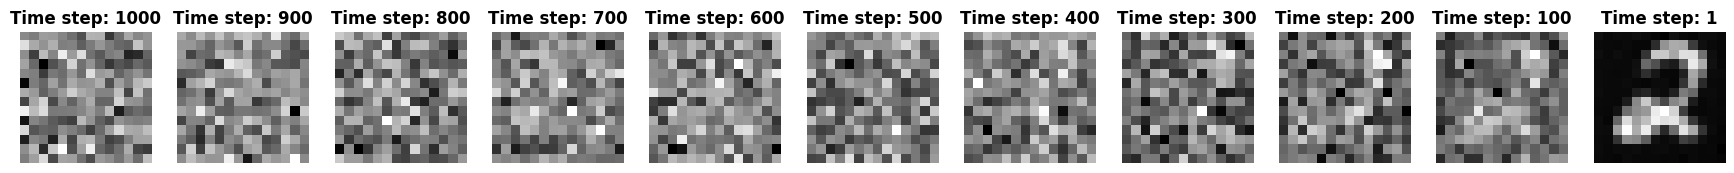

In [8]:
_, trajectory = ddpm_diffusion_model.denoise(model=model, num_samples=1, channels=1, img_size=14)

step = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 1] # define step labels

fig, axis = plt.subplots(nrows=1, ncols=11, figsize=(22, 2))
j = 0
for ax, _ in zip(axis.ravel(), range(11)):
    ax.imshow(trajectory[j][0].detach().cpu().permute(1, 2, 0), cmap='gray')
    ax.set_title(f'Time step: {step[j]}', fontweight='bold')
    ax.axis(False)
    j += 1
plt.show()

## Show progress per trained epoch

In [11]:
saved_results_exist = os.path.exists(os.path.join(os.getcwd(), "X_d3_n50.pt"))

In [50]:
examined_models_idx = range(0, len(models), 1)

if not saved_results_exist:
    d = 3
    output_list = []
    for idx in examined_models_idx:
        model = torch.load(models[idx]["path"], weights_only=False)

        output, _ = ddpm_diffusion_model.denoise(model=model, num_samples=d, channels=1, img_size=14)
        output_list.append(F.interpolate(output, [28, 28]))

    d_results_per_epoch = torch.stack(output_list)
    denoised_images = f'X_d{d}_n{len(models)}.pt'
    torch.save(d_results_per_epoch, denoised_images)
else:
    d_results_per_epoch = torch.load("X_d3_n50.pt")

In [13]:
cnn = torch.load("mnist_trained_cnn.pt", weights_only=False) #cnn trained on mnist (test-acc : 0.9878)
softmax = nn.Softmax(dim=1)

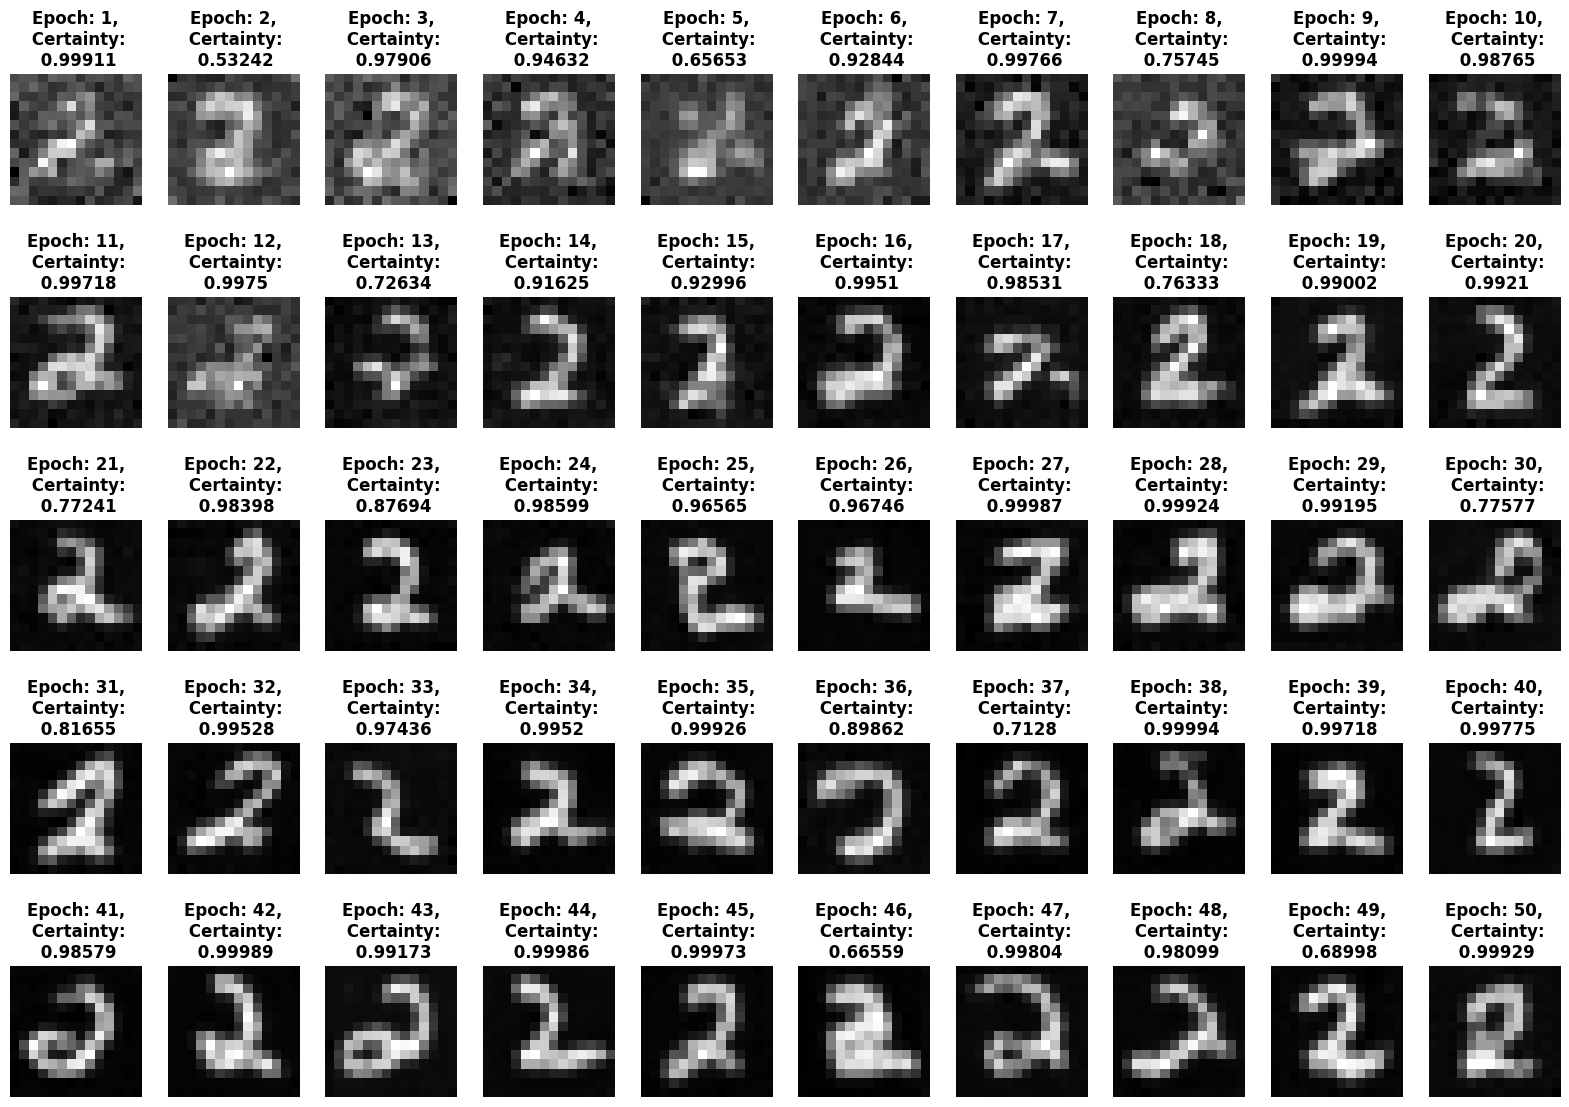

In [52]:
fig, axis = plt.subplots(
    nrows=math.ceil(len(examined_models_idx) / 10),
    ncols=10,
    figsize=((len(d_results_per_epoch) // 5) * 2, 14)
)

mean_correct_classification_prob_per_epoch = []

for ax, idx, model_index in zip(axis.ravel(), range(len(d_results_per_epoch)), examined_models_idx):
    output = d_results_per_epoch[model_index,...]
    cnn_out = cnn(output)
    prob = softmax(cnn_out)
    wanted_probs = prob[:,wanted_class]
    mean_probability = wanted_probs.mean().item()
    mean_correct_classification_prob_per_epoch.append(mean_probability)

    ax.imshow(output[0].detach().cpu().permute(1, 2, 0), cmap='gray') # output[0] -> only show first image
    ax.set_title(f'Epoch: {model_index + 1},\n Certainty:\n {round(mean_probability, 5)}', fontweight='bold')
    ax.axis(False)

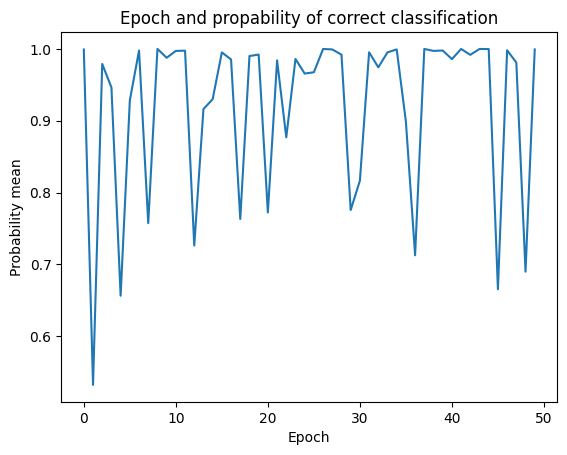

In [54]:
plt.plot(examined_models_idx, mean_correct_classification_prob_per_epoch)
plt.title("Epoch and propability of correct classification")
plt.xlabel("Epoch")
plt.ylabel("Probability mean")
plt.show()

While the results of the graph above are restricted by the small number of generated samples per epoch (3), it hints either both or one of the following:
* the small number of generated samples are not enough to verify the quality of a diffusion model with this technique
* the training process of the diffusion model itself fluctuates in its result quality with partly hugh differences to the previous and following epoch